In [22]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from decimal import Decimal

from sklearn.metrics import pairwise_distances, mean_squared_error
from scipy.spatial.distance import cosine, correlation
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
rating_columns = (['user_id','movie_id', 'rating', 'unix_timestamp'])
ratings = pd.read_csv('../Datasets/ml-100k/u.data',sep='\t',header=None, names=rating_columns)

u_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv('../Datasets/ml-100k/u.user', sep='|', names=u_cols,encoding='latin-1', parse_dates=True) 

m_cols = ['movie_id', 'title' ,'release date','video release date', 'IMDb URL', 'unknown', 'Action', 'Adventure',
 'Animation', 'Children\'s', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']

movies = pd.read_csv('../Datasets/ml-100k/u.item', sep='|', names=m_cols, encoding='latin-1')

In [3]:
ratings.head().sort_values('movie_id')

,user_id,movie_id,rating,unix_timestamp
3,244,51,2,880606923
0,196,242,3,881250949
1,186,302,3,891717742
4,166,346,1,886397596
2,22,377,1,878887116


In [4]:
users.head()

,user_id,age,sex,occupation,zip_code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


In [5]:
movies.head()

,movie_id,title,release date,video release date,IMDb URL,unknown,Action,Adventure,Animation,Children's,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [7]:
print(ratings['movie_id'].nunique())
print(movies['movie_id'].nunique())
print(ratings['user_id'].nunique())
print(users['user_id'].nunique())

1682
1682
943
943


In [6]:
#Drop the timestamp column
ratings = ratings.drop('unix_timestamp', axis=1)

In [9]:
#Assign X as the original ratings dataframe and y as the user_id column of ratings.
X = ratings.copy()
y = ratings['user_id']

#Split into training and test datasets, stratified along user_id
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, stratify=y, random_state=42)

In [11]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [12]:
#Define the baseline model to always return 3.
def baseline(user_id, movie_id):
    return 3.0

In [13]:
#Function to compute the RMSE score obtained on the testing set by a model
def score(cf_model):
    
    #Construct a list of user-movie tuples from the testing dataset
    id_pairs = zip(X_test['user_id'], X_test['movie_id'])
    
    #Predict the rating for every user-movie tuple
    y_pred = np.array([cf_model(user, movie) for (user, movie) in id_pairs])
    
    #Extract the actual ratings given by the users in the test data
    y_true = np.array(X_test['rating'])
    
    #Return the final RMSE score
    return rmse(y_true, y_pred)

In [14]:
score(baseline)

1.2470926188539486

#### User based CF

In [15]:
# Convert the running list of user ratings into a matrix
ratings_mat = X_train.pivot_table(values='rating', index='user_id', columns='movie_id')

In [16]:
ratings_mat.head()

movie_id,1,2,3,4,5,6,7,8,9,10,...,1669,1670,1671,1673,1674,1675,1676,1679,1681,1682
user_id,,,,,,,,,,,,,,,,,,,,,
1,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
#User Based Collaborative Filter using Mean Ratings
def cf_user_mean(user_id, movie_id):
    
    #Check if movie_id exists in r_matrix
    if movie_id in ratings_mat:
        #Compute the mean of all the ratings given to the movie
        mean_rating = ratings_mat[movie_id].mean()
    
    else:
        #Default to a rating of 3.0 in the absence of any information
        mean_rating = 3.0
    
    return mean_rating

In [20]:
#Compute RMSE for the Mean model
score(cf_user_mean)

1.0234701463131335

#### Weighted mean

In [21]:
#Create a dummy ratings matrix with all null values imputed to 0
ratings_mat_dummy = ratings_mat.copy().fillna(0)

In [23]:
#Compute the cosine similarity matrix using the dummy ratings matrix
cosine_sim = cosine_similarity(ratings_mat_dummy, ratings_mat_dummy)

In [24]:
#Convert into pandas dataframe 
cosine_sim = pd.DataFrame(cosine_sim, index=ratings_mat.index, columns=ratings_mat.index)

cosine_sim.head(10)

user_id,1,2,3,4,5,6,7,8,9,10,...,934,935,936,937,938,939,940,941,942,943
user_id,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.118076,0.029097,0.011628,0.264677,0.312419,0.308729,0.224269,0.026017,0.286411,...,0.308475,0.055872,0.197862,0.131367,0.152449,0.084456,0.293293,0.056765,0.103536,0.326491
2,0.118076,1.000000,0.099097,0.107680,0.034279,0.152789,0.086705,0.078864,0.068940,0.092399,...,0.086927,0.259636,0.289092,0.318824,0.149105,0.186347,0.168034,0.106748,0.136796,0.080358
3,0.029097,0.099097,1.000000,0.252131,0.026893,0.062539,0.039767,0.089474,0.078162,0.037670,...,0.040918,0.019031,0.065417,0.055373,0.086503,0.018418,0.096993,0.109631,0.092574,0.018987
4,0.011628,0.107680,0.252131,1.000000,0.000000,0.045543,0.078812,0.095354,0.059498,0.053879,...,0.024226,0.050703,0.056561,0.107294,0.098892,0.000000,0.132900,0.142798,0.097066,0.015176
5,0.264677,0.034279,0.026893,0.000000,1.000000,0.202843,0.299619,0.163724,0.038474,0.153021,...,0.262547,0.048524,0.048312,0.022202,0.091910,0.066000,0.156172,0.115842,0.124297,0.267574
6,0.312419,0.152789,0.062539,0.045543,0.202843,1.000000,0.375963,0.131795,0.110944,0.400758,...,0.287549,0.080312,0.162988,0.182856,0.114262,0.092090,0.261859,0.097606,0.206104,0.187637
7,0.308729,0.086705,0.039767,0.078812,0.299619,0.375963,1.000000,0.211282,0.107795,0.328923,...,0.290002,0.074170,0.094619,0.084235,0.115620,0.100625,0.233843,0.039199,0.224227,0.296332
8,0.224269,0.078864,0.089474,0.095354,0.163724,0.131795,0.211282,1.000000,0.037040,0.183375,...,0.165008,0.066843,0.058766,0.068759,0.087159,0.129381,0.188662,0.121223,0.083910,0.273238
9,0.026017,0.068940,0.078162,0.059498,0.038474,0.110944,0.107795,0.037040,1.000000,0.155435,...,0.011708,0.000000,0.101710,0.034568,0.045002,0.052699,0.107486,0.055766,0.070065,0.088281


In [25]:
#User Based Collaborative Filter using Weighted Mean Ratings
def cf_user_wmean(user_id, movie_id):
    
    #Check if movie_id exists in r_matrix
    if movie_id in ratings_mat:
        
        #Get the similarity scores for the user in question with every other user
        sim_scores = cosine_sim[user_id]
        
        #Get the user ratings for the movie in question
        m_ratings = ratings_mat[movie_id]
        
        #Extract the indices containing NaN in the m_ratings series
        idx = m_ratings[m_ratings.isnull()].index
        
        #Drop the NaN values from the m_ratings Series
        m_ratings = m_ratings.dropna()
        
        #Drop the corresponding cosine scores from the sim_scores series
        sim_scores = sim_scores.drop(idx)
        
        #Compute the final weighted mean
        wmean_rating = np.dot(sim_scores, m_ratings)/ sim_scores.sum()
    
    else:
        #Default to a rating of 3.0 in the absence of any information
        wmean_rating = 3.0
    
    return wmean_rating

In [26]:
score(cf_user_wmean)

1.0174483808407588

#### Demographics

In [27]:
#Merge the original users dataframe with the training set 
merged_df = pd.merge(X_train, users)

merged_df.head()

,user_id,movie_id,rating,age,sex,occupation,zip_code
0,889,684,2,24,M,technician,78704
1,889,279,2,24,M,technician,78704
2,889,29,3,24,M,technician,78704
3,889,190,3,24,M,technician,78704
4,889,232,3,24,M,technician,78704


In [36]:
#Compute the mean rating of every movie by gender
gender_mean = merged_df[['movie_id', 'sex', 'rating']].groupby(['movie_id','sex'])['rating'].mean()
#gender_mean

In [31]:
#Set the index of the users dataframe to the user_id
users = users.set_index('user_id')

In [37]:
#Gender Based Collaborative Filter using Mean Ratings
def cf_gender(user_id, movie_id):
    
    #Check if movie_id exists in r_matrix (or training set)
    if movie_id in ratings_mat:
        #Identify the gender of the user
        gender = users.loc[user_id]['sex']
        
        #Check if the gender has rated the movie
        if gender in gender_mean[movie_id]:
            
            #Compute the mean rating given by that gender to the movie
            gender_rating = gender_mean[movie_id][gender]
        
        else:
            gender_rating = 3.0
    
    else:
        #Default to a rating of 3.0 in the absence of any information
        gender_rating = 3.0
    
    return gender_rating

In [38]:
score(cf_gender)

1.0330308800874282

In [39]:
#Compute the mean rating by gender and occupation
gen_occ_mean = merged_df[['sex', 'rating', 'movie_id', 'occupation']].pivot_table(
    values='rating', index='movie_id', columns=['occupation', 'sex'], aggfunc='mean')

gen_occ_mean.head()

occupation administrator           artist              doctor educator  \
sex                    F         M      F         M         M        F   
movie_id                                                                 
1                    4.0  4.222222   4.25  3.500000  3.666667     3.50   
2                    3.0  3.750000    NaN       NaN       NaN      NaN   
3                    3.5  2.500000    NaN       NaN       NaN     4.00   
4                    3.0  3.888889    NaN  4.666667  3.000000     2.75   
5                    4.0  2.333333    NaN       NaN       NaN     4.00   

occupation           engineer           entertainment    ...    salesman  \
sex                M        F         M             F    ...           F   
movie_id                                                 ...               
1           3.923077      4.0  3.970588           5.0    ...         4.0   
2           3.250000      NaN  3.363636           NaN    ...         NaN   
3           2.500000      NaN  3.625000           NaN    ...         NaN   
4           3.636364      NaN  3.555556           NaN    ...         4.0   
5           1.500000      NaN  2.666667           NaN    ...         NaN   

occupation           scientist             student           technician  \
sex                M         F         M         F         M          F   
movie_id                                                                  
1           4.000000       3.5  3.888889  3.833333  3.709091        4.0   
2                NaN       NaN       NaN  2.333333  3.333333        NaN   
3           1.000000       NaN       NaN  2.000000  3.217391        NaN   
4           3.666667       NaN  3.600000  3.285714  3.724138        NaN   
5                NaN       NaN  3.500000  4.333333  3.272727        NaN   

occupation              writer            
sex                M         F         M  
movie_id                                  
1           4.200000  4.166667  3.142857  
2           2.714286  5.000000  2.666667  
3           4.000000       NaN  1.000000  
4           3.200000  4.250000  3.500000  
5           3.333333  4.000000  2.666667  

[5 rows x 41 columns]

In [40]:
#Gender and Occupation Based Collaborative Filter using Mean Ratings
def cf_gen_occ(user_id, movie_id):
    
    #Check if movie_id exists in gen_occ_mean
    if movie_id in gen_occ_mean.index:
        
        #Identify the user
        user = users.loc[user_id]
        
        #Identify the gender and occupation
        gender = user['sex']
        occ = user['occupation']
        
        #Check if the occupation has rated the movie
        if occ in gen_occ_mean.loc[movie_id]:
            
            #Check if the gender has rated the movie
            if gender in gen_occ_mean.loc[movie_id][occ]:
                
                #Extract the required rating
                rating = gen_occ_mean.loc[movie_id][occ][gender]
                
                #Default to 3.0 if the rating is null
                if np.isnan(rating):
                    rating = 3.0
                
                return rating
            
    #Return the default rating    
    return 3.0

In [41]:
score(cf_gen_occ)

1.1391976012043645

In [9]:
x = pd.merge(movies, ratings )
indata = pd.merge(x, users)

In [10]:
indata.head()

,movie_id,title,release_date,video_release_date,imdb_url,user_id,rating,unix_timestamp,age,sex,occupation,zip_code
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,308,4,887736532,60,M,retired,95076
1,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,308,5,887737890,60,M,retired,95076
2,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),308,4,887739608,60,M,retired,95076
3,7,Twelve Monkeys (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Twelve%20Monk...,308,4,887738847,60,M,retired,95076
4,8,Babe (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Babe%20(1995),308,5,887736696,60,M,retired,95076


In [11]:
indata.describe().round()

,movie_id,video_release_date,user_id,rating,unix_timestamp,age
count,100000.0,0.0,100000.0,100000.0,100000.0,100000.0
mean,426.0,NaN,462.0,4.0,883528851.0,33.0
std,331.0,NaN,267.0,1.0,5343856.0,12.0
min,1.0,NaN,1.0,1.0,874724710.0,7.0
25%,175.0,NaN,254.0,3.0,879448710.0,24.0
50%,322.0,NaN,447.0,4.0,882826944.0,30.0
75%,631.0,NaN,682.0,4.0,888259984.0,40.0
max,1682.0,NaN,943.0,5.0,893286638.0,73.0


In [29]:
# Convert the running list of user ratings into a matrix
ratings_df = pd.pivot_table(indata,values='rating', index='user_id', columns='movie_id').fillna(0)

In [30]:
ratings_df.head()

movie_id,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
user_id,,,,,,,,,,,,,,,,,,,,,
1,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
indata.isnull().sum()

movie_id                   0
title                      0
release_date               9
video_release_date    100000
imdb_url                  13
user_id                    0
rating                     0
unix_timestamp             0
age                        0
sex                        0
occupation                 0
zip_code                   0
dtype: int64

In [15]:
indata.drop(columns=['video_release_date','imdb_url'],inplace=True)

In [16]:
movie_stats = indata.groupby('title').agg({'rating': [np.size, np.mean]})

In [17]:
min_50 = movie_stats['rating']['size'] >= 50
movie_stats[min_50].sort_values([('rating', 'mean')], ascending=False).head()

rating          
                                                     size      mean
title                                                              
Close Shave, A (1995)                                 112  4.491071
Schindler's List (1993)                               298  4.466443
Wrong Trousers, The (1993)                            118  4.466102
Casablanca (1942)                                     243  4.456790
Wallace & Gromit: The Best of Aardman Animation...     67  4.447761

In [18]:
movie_stats[min_50].sort_values([('rating', 'size')], ascending=False).head()

rating          
                            size      mean
title                                     
Star Wars (1977)             583  4.358491
Contact (1997)               509  3.803536
Fargo (1996)                 508  4.155512
Return of the Jedi (1983)    507  4.007890
Liar Liar (1997)             485  3.156701

In [19]:
movie_stats.describe()

rating             
              size         mean
count  1664.000000  1664.000000
mean     60.096154     3.077018
std      80.956484     0.780418
min       1.000000     1.000000
25%       7.000000     2.665094
50%      27.000000     3.162132
75%      80.250000     3.651808
max     583.000000     5.000000

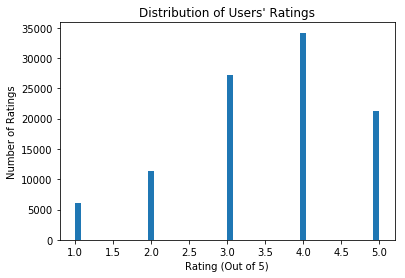

In [25]:
ratings.rating.plot.hist(bins=50)
plt.title("Distribution of Users' Ratings")
plt.ylabel('Number of Ratings')
plt.xlabel('Rating (Out of 5)');

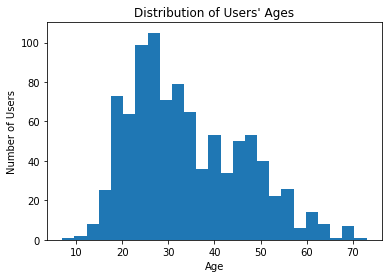

In [26]:
users.age.plot.hist(bins=25)
plt.title("Distribution of Users' Ages")
plt.ylabel('Number of Users')
plt.xlabel('Age');

### Cosine Similarity

In [53]:
user_similarity = 1 - pairwise_distances( ratings_df.as_matrix(), metric="cosine" )
np.fill_diagonal( user_similarity, 0 ) #Filling diagonals with 0s for future use when sorting is done
user_ratings_matrix = pd.DataFrame( user_similarity )
user_ratings_matrix.head(5)

,0,1,2,3,4,5,6,7,8,9,...,933,934,935,936,937,938,939,940,941,942
0,0.000000,0.166931,0.047460,0.064358,0.378475,0.430239,0.440367,0.319072,0.078138,0.376544,...,0.369527,0.119482,0.274876,0.189705,0.197326,0.118095,0.314072,0.148617,0.179508,0.398175
1,0.166931,0.000000,0.110591,0.178121,0.072979,0.245843,0.107328,0.103344,0.161048,0.159862,...,0.156986,0.307942,0.358789,0.424046,0.319889,0.228583,0.226790,0.161485,0.172268,0.105798
2,0.047460,0.110591,0.000000,0.344151,0.021245,0.072415,0.066137,0.083060,0.061040,0.065151,...,0.031875,0.042753,0.163829,0.069038,0.124245,0.026271,0.161890,0.101243,0.133416,0.026556
3,0.064358,0.178121,0.344151,0.000000,0.031804,0.068044,0.091230,0.188060,0.101284,0.060859,...,0.052107,0.036784,0.133115,0.193471,0.146058,0.030138,0.196858,0.152041,0.170086,0.058752
4,0.378475,0.072979,0.021245,0.031804,0.000000,0.237286,0.373600,0.248930,0.056847,0.201427,...,0.338794,0.080580,0.094924,0.079779,0.148607,0.071459,0.239955,0.139595,0.152497,0.313941


In [54]:
movie_similarity = 1 - pairwise_distances( ratings_df.as_matrix().T, metric="cosine" )
np.fill_diagonal( movie_similarity, 0 ) #Filling diagonals with 0s for future use when sorting is done
movie_ratings_matrix = pd.DataFrame( movie_similarity )
movie_ratings_matrix.head(5)

,0,1,2,3,4,5,6,7,8,9,...,1672,1673,1674,1675,1676,1677,1678,1679,1680,1681
0,0.000000,0.402382,0.330245,0.454938,0.286714,0.116344,0.620979,0.481114,0.496288,0.273935,...,0.035387,0.0,0.000000,0.000000,0.035387,0.0,0.0,0.0,0.047183,0.047183
1,0.402382,0.000000,0.273069,0.502571,0.318836,0.083563,0.383403,0.337002,0.255252,0.171082,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.078299,0.078299
2,0.330245,0.273069,0.000000,0.324866,0.212957,0.106722,0.372921,0.200794,0.273669,0.158104,...,0.000000,0.0,0.000000,0.000000,0.032292,0.0,0.0,0.0,0.000000,0.096875
3,0.454938,0.502571,0.324866,0.000000,0.334239,0.090308,0.489283,0.490236,0.419044,0.252561,...,0.000000,0.0,0.094022,0.094022,0.037609,0.0,0.0,0.0,0.056413,0.075218
4,0.286714,0.318836,0.212957,0.334239,0.000000,0.037299,0.334769,0.259161,0.272448,0.055453,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.094211


In [64]:
movies['title'].head(10)

0                                     Toy Story (1995)
1                                     GoldenEye (1995)
2                                    Four Rooms (1995)
3                                    Get Shorty (1995)
4                                       Copycat (1995)
5    Shanghai Triad (Yao a yao yao dao waipo qiao) ...
6                                Twelve Monkeys (1995)
7                                          Babe (1995)
8                              Dead Man Walking (1995)
9                                   Richard III (1995)
Name: title, dtype: object

In [65]:
#try:
    #user_inp=input('Enter the reference movie title based on which recommendations are to be made: ')
user_inp=movies['title'].iloc[7]
inp=movies[movies['title']==user_inp].index.tolist()
#inp
inp=inp[0]
    
movies['similarity'] = movie_ratings_matrix.iloc[inp]
#movies.columns = ['movie_id', 'title', 'release_date','similarity']
movies.head(10).sort_values('similarity',ascending=False)
    
#except:
#    print("Sorry, the movie is not in the database!")

,movie_id,title,release_date,video_release_date,imdb_url,similarity
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0.490236
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0.481114
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0.337002
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0.259161
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0.200794


In [50]:
print("Recommended movies based on your choice of ",user_inp ,": \n", movies.sort_values( ["similarity"], ascending = False )[1:10])

Recommended movies based on your choice of  GoldenEye (1995) : 
      movie_id                                              title release_date  \
930       931                   Island of Dr. Moreau, The (1996)  23-Aug-1996   
459       460                         Crossing Guard, The (1995)  01-Jan-1995   
130       131                      Breakfast at Tiffany's (1961)  01-Jan-1961   
103       104                                Theodore Rex (1995)  29-Mar-1996   
734       735                                Philadelphia (1993)  01-Jan-1993   
412       413  Tales from the Crypt Presents: Bordello of Blo...  19-Jul-1996   
14         15                          Mr. Holland's Opus (1995)  29-Jan-1996   
485       486                                     Sabrina (1954)  01-Jan-1954   
833       834       Halloween: The Curse of Michael Myers (1995)  01-Jan-1995   

     video_release_date                                           imdb_url  \
930                 NaN  http://us.imdb.com/M/

In [40]:
movies.head()

,movie_id,title,release_date,video_release_date,imdb_url,similarity
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0.000000
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0.166931
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0.047460
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0.064358
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0.378475


In [42]:
movies['title'].iloc[1]

'GoldenEye (1995)'

In [26]:
R = ratings_df.as_matrix()
user_ratings_mean = np.mean(R, axis = 1)
R_demeaned = R - user_ratings_mean.reshape(-1, 1)

In [28]:
R_demeaned.shape

(943, 1682)

In [31]:
pd.DataFrame(R_demeaned).head()

,0,1,2,3,4,5,6,7,8,9,...,1672,1673,1674,1675,1676,1677,1678,1679,1680,1681
0,4.416171,2.416171,3.416171,2.416171,2.416171,4.416171,3.416171,0.416171,4.416171,2.416171,...,-0.583829,-0.583829,-0.583829,-0.583829,-0.583829,-0.583829,-0.583829,-0.583829,-0.583829,-0.583829
1,3.863258,-0.136742,-0.136742,-0.136742,-0.136742,-0.136742,-0.136742,-0.136742,-0.136742,1.863258,...,-0.136742,-0.136742,-0.136742,-0.136742,-0.136742,-0.136742,-0.136742,-0.136742,-0.136742,-0.136742
2,-0.089774,-0.089774,-0.089774,-0.089774,-0.089774,-0.089774,-0.089774,-0.089774,-0.089774,-0.089774,...,-0.089774,-0.089774,-0.089774,-0.089774,-0.089774,-0.089774,-0.089774,-0.089774,-0.089774,-0.089774
3,-0.061831,-0.061831,-0.061831,-0.061831,-0.061831,-0.061831,-0.061831,-0.061831,-0.061831,-0.061831,...,-0.061831,-0.061831,-0.061831,-0.061831,-0.061831,-0.061831,-0.061831,-0.061831,-0.061831,-0.061831
4,3.700951,2.700951,-0.299049,-0.299049,-0.299049,-0.299049,-0.299049,-0.299049,-0.299049,-0.299049,...,-0.299049,-0.299049,-0.299049,-0.299049,-0.299049,-0.299049,-0.299049,-0.299049,-0.299049,-0.299049
